In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error 

from dataloader import TRAILDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
def create_sequence_dataset(data, lookback, output_length=4):
    X, y = [], []
    for i in tqdm(range(0, len(data) - lookback - output_length + 1, output_length), desc="Generating sequences"):
        
        X.append(data.iloc[i : i + lookback, :].values)
        y.append(data.iloc[i + lookback : i + lookback + output_length, -1].values)
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    
    return X_tensor, y_tensor

In [4]:
def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in tqdm(val_loader, desc='Validation', position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [5]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for X_batch, y_batch in tqdm(train_loader, desc='Training',position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss = validate_model(model, criterion, val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    print('Finished Training')
    
    return train_losses, val_losses


In [6]:
def denorm_tensor(x, min_, max_):
    return x * (max_ - min_) + min_

In [7]:
def test_model(model, test_loader, predict_scaler):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in tqdm(test_loader, desc='Validation', position=0, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)

            # apply reverse scaling
            max_ = torch.tensor(predict_scaler.data_max_).to(device)
            min_ = torch.tensor(predict_scaler.data_min_).to(device)
            
            y_batch_ = denorm_tensor(y_batch, min_, max_)
            outputs_ = denorm_tensor(outputs, min_, max_)
        
            y_true.append(y_batch_)
            y_pred.append(outputs_)
    
    
    y_true = [tensor.cpu().numpy() for tensor in y_true]
    y_pred = [tensor.cpu().numpy() for tensor in y_pred]
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    
    mse_per_output = []
    rmse_per_output = []
    mape_per_output = []
    
    for i in range(y_true.shape[1]):
        mse_value = mean_squared_error(y_true[:, i], y_pred[:, i])
        rmse_value = np.sqrt(mse_value)
        mape_value = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])

        mse_per_output.append(mse_value)
        rmse_per_output.append(rmse_value)
        mape_per_output.append(mape_value)

        print(f"Output {i+1}: MSE: {mse_value:.4f}, RMSE: {rmse_value:.4f}, MAPE: {mape_value:.4f}%")
        
    
    return mse_per_output, rmse_per_output, mape_per_output

In [8]:
def get_predictions(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            
            y_true.append(y_batch.cpu().numpy())
            y_pred.append(outputs.cpu().numpy())
    
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    
    return y_true, y_pred

In [9]:
def plot_true_vs_predicted(y_true, y_pred, time=None):
    if time is None:
        time = np.arange(len(y_true))
    
    plt.figure(figsize=(18, 6))
    plt.plot(time, y_true, color='blue', label='True Values')
    plt.plot(time, y_pred, color='red', label='Predicted Values')
    
    plt.ylabel('Total Load')
    plt.title('True Values vs Predicted Values')
    plt.legend()
    plt.show()


In [10]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
def evaluate_final_test_metrics(truth, predictions):
    t0_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][::4], predictions["Prediction"][::4]))
    t1_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][1::4], predictions["Prediction"][1::4]))
    t2_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][2::4], predictions["Prediction"][2::4]))
    t3_rmse = np.sqrt(mean_squared_error(truth["Total Load Interpolated"][3::4], predictions["Prediction"][3::4]))

    t0_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][::4], predictions["Prediction"][::4])
    t1_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][1::4], predictions["Prediction"][1::4])
    t2_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][2::4], predictions["Prediction"][2::4])
    t3_mape = mean_absolute_percentage_error(truth["Total Load Interpolated"][3::4], predictions["Prediction"][3::4])

    print("|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|")
    print("| |", str(t0_rmse)[:7], "|", str(t1_rmse)[:7], "|", str(t2_rmse)[:7], "|", str(t3_rmse)[:7],
        "|", str(t0_mape)[:7], "|", str(t1_mape)[:7], "|", str(t2_mape)[:7], "|", str(t3_mape)[:7], "|", sep="")

In [12]:
class RNNVectorOutput(nn.Module):
    def __init__(self,input_size, output_size, num_layers=2):
        super(RNNVectorOutput, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=20, num_layers=num_layers, batch_first=True)
        self.linear_1 = nn.Linear(20, output_size)
        self.sigmoid = nn.Sigmoid()  
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear_1(x[:, -1, :])
        return x

In [13]:
class LSTMVectorOutput(nn.Module):
    def __init__(self,input_size, output_size, num_layers=2):
        super(LSTMVectorOutput, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=16, num_layers=num_layers, batch_first=True)
        self.linear_1 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()  
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear_1(x[:, -1, :])
        x = self.sigmoid(x)
        return x

In [14]:
class GRUVectorOutput(nn.Module):
    def __init__(self,input_size, output_size, num_layers=2):
        super(GRUVectorOutput, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=16, num_layers=num_layers, batch_first=True)
        self.linear_1 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()  
    
    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.linear_1(x[:, -1, :])
        return x

In [15]:
seed_value = 40

torch.manual_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [16]:
HORIZON = 4
LAG = 4 * 24 + HORIZON
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 8

**Loading the data and splitting it into training, validation, and test sets**

In [17]:
csv_file = "Processed_data.csv"
df = pd.read_csv(csv_file, sep=",") 
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Weekday'] = df['Datetime'].dt.weekday
df = df.set_index('Datetime')

In [18]:
df_train = df[df["Year"] < 2023]
df_val = df[df["Year"] == 2023]

In [19]:
# Final test set
truth = df.iloc[335428 : 338404].copy()
truth.to_csv('truth.csv', index = False)

df_final_test = df.iloc[335428-LAG : 338404]

In [20]:
columns_input = ['Total Load Interpolated']  
column_to_predict = 'Total Load Interpolated'
column_to_normalize = ['Total Load Interpolated']

In [21]:
train_dataset = TRAILDataset(df_train, len(df_train), columns_input, column_to_predict, column_to_normalize)

scaler = train_dataset.get_scaler()
predict_scaler = train_dataset.get_predict_scaler()

train_dataset.save_scaler()

predict_scaler = train_dataset.get_predict_scaler()
print("train dataset loaded")
print(column_to_normalize)

val_dataset = TRAILDataset(df_val, len(df_val), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("validation dataset loaded")

final_test_dataset = TRAILDataset(df_final_test, len(df_final_test), columns_input, column_to_predict, column_to_normalize, scaler=scaler, predict_scaler=predict_scaler)
print("final test dataset loaded")


train dataset loaded
['Total Load Interpolated']
validation dataset loaded
final test dataset loaded


c:\Users\tojov\Desktop\Workshop_2024\project9 - Copie\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_to_predict] = scaled_row
c:\Users\tojov\Desktop\Workshop_2024\project9 - Copie\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[self.column_to_predict] = scaled_row
c:\Users\tojov\Desktop\Workshop_2024\project9 - Copie\dataloader.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [22]:
train_dataset.data = train_dataset.data[['Total Load Interpolated']]
val_dataset.data = val_dataset.data[['Total Load Interpolated']]

final_test_dataset.data = final_test_dataset.data[['Total Load Interpolated']]

### **Sequence generation**

In [23]:
X_train, y_train = create_sequence_dataset( train_dataset.data, lookback=LAG, output_length=HORIZON)
X_val, y_val = create_sequence_dataset( val_dataset.data, lookback=LAG, output_length=HORIZON)

X_final_test, y_final_test = create_sequence_dataset( final_test_dataset.data, lookback=LAG, output_length=HORIZON)

Generating sequences: 100%|██████████| 70104/70104 [00:11<00:00, 5987.54it/s]
c:\Python37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  
Generating sequences: 100%|██████████| 744/744 [00:00<00:00, 6416.09it/s]


In [24]:
train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=False)
val_loader = data.DataLoader(data.TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

final_test_loader = data.DataLoader(data.TensorDataset(X_final_test, y_final_test), batch_size=BATCH_SIZE, shuffle=False)

### **Model creation and training**

In [25]:
rnn_model =  RNNVectorOutput(input_size=len(train_dataset.data.columns),output_size=HORIZON, num_layers= 1)
lstm_model =  LSTMVectorOutput(input_size=len(train_dataset.data.columns),output_size=HORIZON, num_layers= 1)
gru_model =  GRUVectorOutput(input_size=len(train_dataset.data.columns),output_size=HORIZON, num_layers= 1)

In [26]:
criterion = nn.MSELoss()

**RNN**

Epoch 1/20, Training Loss: 0.0041, Validation Loss: 0.0010


Epoch 2/20, Training Loss: 0.0008, Validation Loss: 0.0008


Epoch 3/20, Training Loss: 0.0007, Validation Loss: 0.0008


Epoch 4/20, Training Loss: 0.0006, Validation Loss: 0.0007


Epoch 5/20, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 6/20, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 7/20, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 8/20, Training Loss: 0.0004, Validation Loss: 0.0007


Epoch 9/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 10/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 11/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 12/20, Training Loss: 0.0003, Validation Loss: 0.0006


Epoch 13/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 14/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 15/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 16/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 17/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 18/20, Training Loss: 0.0003, Validation Loss: 0.0006


Epoch 19/20, Training Loss: 0.0003, Validation Loss: 0.0006


Epoch 20/20, Training Loss: 0.0003, Validation Loss: 0.0006
Finished Training


Output 1: MSE: 9438.5400, RMSE: 97.1521, MAPE: 0.0095%
Output 2: MSE: 25041.6119, RMSE: 158.2454, MAPE: 0.0154%
Output 3: MSE: 37700.4855, RMSE: 194.1661, MAPE: 0.0187%
Output 4: MSE: 52408.1728, RMSE: 228.9283, MAPE: 0.0216%
|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|
| |97.1521|158.245|194.166|228.928|0.00947|0.01543|0.01865|0.02160|


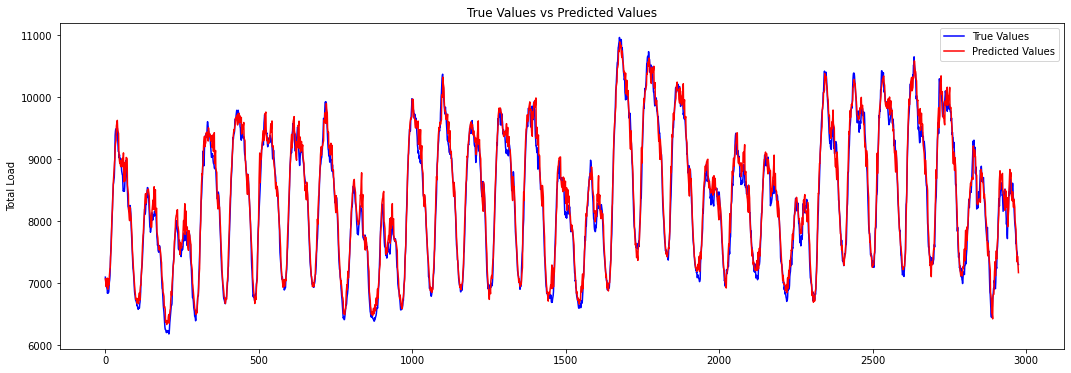

In [27]:
rnn_model.to(device)
optimizer = optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)

# Training
train_losses, val_losses = train_model(rnn_model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS)  

# evaluation on the final Test
mse_values, rmse_values, mape_values = test_model(rnn_model, final_test_loader, predict_scaler)


y_true, y_pred_rnn = get_predictions(rnn_model, final_test_loader)
y_true, y_pred_rnn = y_true.reshape(-1) , y_pred_rnn.reshape(-1)

# apply reverse scaling
y_true = predict_scaler.inverse_transform(y_true.reshape(-1,1))
y_pred_rnn = predict_scaler.inverse_transform(y_pred_rnn.reshape(-1,1))

# saving prediction to csv file
rnn_predictions = pd.DataFrame(y_pred_rnn, columns=['Prediction'])
rnn_predictions.to_csv('rnn_result.csv',index=False)

# evaluation on the final test set
evaluate_final_test_metrics(truth, rnn_predictions)

# compare true values vs predicted values
plot_true_vs_predicted(y_true, y_pred_rnn)

**LSTM**

Epoch 1/20, Training Loss: 0.0036, Validation Loss: 0.0011


Epoch 2/20, Training Loss: 0.0008, Validation Loss: 0.0008


Epoch 3/20, Training Loss: 0.0006, Validation Loss: 0.0008


Epoch 4/20, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 5/20, Training Loss: 0.0005, Validation Loss: 0.0007


Epoch 6/20, Training Loss: 0.0005, Validation Loss: 0.0007


Epoch 7/20, Training Loss: 0.0005, Validation Loss: 0.0007


Epoch 8/20, Training Loss: 0.0005, Validation Loss: 0.0007


Epoch 9/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 10/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 11/20, Training Loss: 0.0006, Validation Loss: 0.0006


Epoch 12/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 13/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 14/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 15/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 16/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 17/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 18/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 19/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 20/20, Training Loss: 0.0003, Validation Loss: 0.0006
Finished Training


Output 1: MSE: 13845.4647, RMSE: 117.6668, MAPE: 0.0114%
Output 2: MSE: 23235.8743, RMSE: 152.4332, MAPE: 0.0145%
Output 3: MSE: 33859.2973, RMSE: 184.0090, MAPE: 0.0176%
Output 4: MSE: 49406.8751, RMSE: 222.2766, MAPE: 0.0213%
|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|
| |117.666|152.433|184.008|222.276|0.01143|0.01452|0.01757|0.02132|


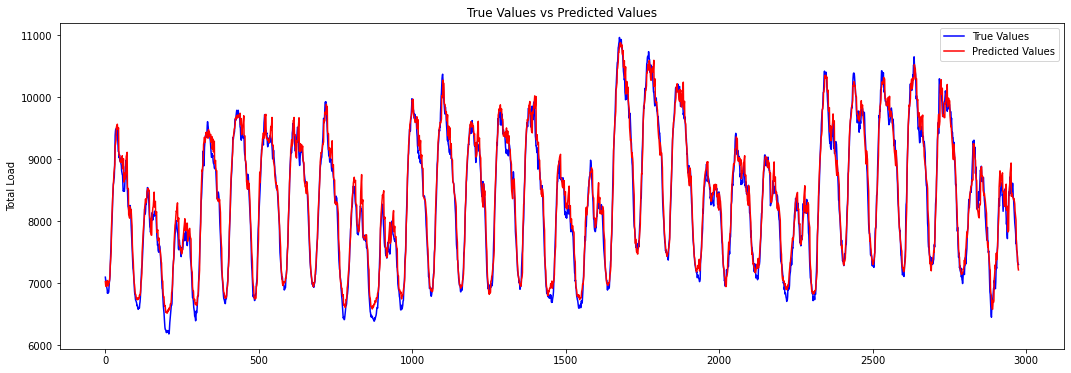

In [28]:
lstm_model.to(device)
optimizer = optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)

# Training
train_losses, val_losses = train_model(lstm_model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS)  

# evaluation on the final Test
mse_values, rmse_values, mape_values = test_model(lstm_model, final_test_loader, predict_scaler)


y_true, y_pred_lstm = get_predictions(lstm_model, final_test_loader)
y_true, y_pred_lstm = y_true.reshape(-1) , y_pred_lstm.reshape(-1)

# apply reverse scaling
y_true = predict_scaler.inverse_transform(y_true.reshape(-1,1))
y_pred_lstm = predict_scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

# saving prediction to csv file
lstm_predictions= pd.DataFrame(y_pred_lstm, columns=['Prediction'])
lstm_predictions.to_csv('lstm_result.csv',index=False)

# evaluation on the final test set
evaluate_final_test_metrics(truth, lstm_predictions)

# compare true values vs predicted values
plot_true_vs_predicted(y_true, y_pred_lstm)

**GRU**

Epoch 1/20, Training Loss: 0.0041, Validation Loss: 0.0009


Epoch 2/20, Training Loss: 0.0009, Validation Loss: 0.0008


Epoch 3/20, Training Loss: 0.0007, Validation Loss: 0.0007


Epoch 4/20, Training Loss: 0.0007, Validation Loss: 0.0007


Epoch 5/20, Training Loss: 0.0006, Validation Loss: 0.0006


Epoch 6/20, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 7/20, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 8/20, Training Loss: 0.0005, Validation Loss: 0.0006


Epoch 9/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 10/20, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 11/20, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 12/20, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 13/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 14/20, Training Loss: 0.0004, Validation Loss: 0.0006


Epoch 15/20, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 16/20, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 17/20, Training Loss: 0.0004, Validation Loss: 0.0005


Epoch 18/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 19/20, Training Loss: 0.0003, Validation Loss: 0.0005


Epoch 20/20, Training Loss: 0.0003, Validation Loss: 0.0005
Finished Training


Output 1: MSE: 8054.8046, RMSE: 89.7486, MAPE: 0.0085%
Output 2: MSE: 20530.9540, RMSE: 143.2863, MAPE: 0.0138%
Output 3: MSE: 29693.9901, RMSE: 172.3194, MAPE: 0.0168%
Output 4: MSE: 42994.0906, RMSE: 207.3502, MAPE: 0.0199%
|Model Name|RMSE t+1|RMSE t+2|RMSE t+3|RMSE t+4|MAPE t+1|MAPE t+2|MAPE t+3|MAPE t+4|
| |89.7485|143.286|172.319|207.350|0.00850|0.01381|0.01676|0.01987|


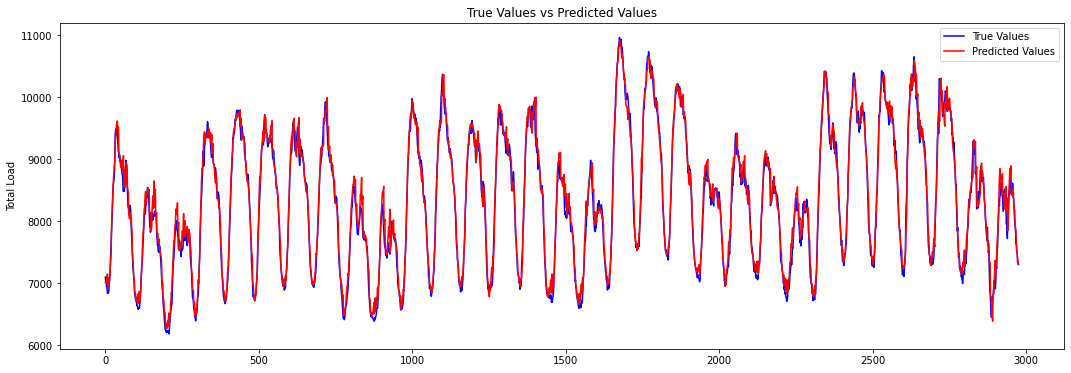

In [29]:
gru_model.to(device)
optimizer = optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)

# Training
train_losses, val_losses = train_model(gru_model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS)  

# evaluation on the final Test
mse_values, rmse_values, mape_values = test_model(gru_model, final_test_loader, predict_scaler)


y_true, y_pred_gru = get_predictions(gru_model, final_test_loader)
y_true, y_pred_gru = y_true.reshape(-1) , y_pred_gru.reshape(-1)

# apply reverse scaling
y_true = predict_scaler.inverse_transform(y_true.reshape(-1,1))
y_pred_gru = predict_scaler.inverse_transform(y_pred_gru.reshape(-1,1))

# saving prediction to csv file
gru_predictions = pd.DataFrame(y_pred_gru, columns=['Prediction'])
gru_predictions.to_csv('gru_result.csv',index=False)

# evaluation on the final test set
evaluate_final_test_metrics(truth, gru_predictions)

# compare true values vs predicted values
plot_true_vs_predicted(y_true, y_pred_gru)
